## Requirements

In [6]:
!pip install -r requirements.txt

  Obtaining dependency information for langgraph from https://files.pythonhosted.org/packages/c0/ed/6435328d51f0a56f42e53f8089ce31479c6e041248de9448652150f83162/langgraph-0.4.7-py3-none-any.whl.metadata
  Using cached langgraph-0.4.7-py3-none-any.whl.metadata (6.8 kB)
  Obtaining dependency information for langgraph-prebuilt from https://files.pythonhosted.org/packages/14/46/c98fec1f8620cbffbabda346a2c68155eec3720c6c3393ab3b9529618810/langgraph_prebuilt-0.2.2-py3-none-any.whl.metadata
  Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl.metadata (4.5 kB)
  Obtaining dependency information for langgraph-sdk from https://files.pythonhosted.org/packages/8c/77/b0930ca5d54ef91e2bdb37e0f7dbeda1923e1e0b5b71ab3af35c103c2e39/langgraph_sdk-0.1.70-py3-none-any.whl.metadata
  Using cached langgraph_sdk-0.1.70-py3-none-any.whl.metadata (1.5 kB)
  Obtaining dependency information for langgraph-checkpoint-sqlite from https://files.pythonhosted.org/packages/c1/ff/63b16d83a513f7d7a5001bb01a40024986


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Simple Graph

### Graph Image

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

### State

First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. 

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

### Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions.

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`.

Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

In [2]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

### Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) are used if you want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [3]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

### Graph Construction

Now, we build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above.

The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above.
 
Then, we add our nodes and edges.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

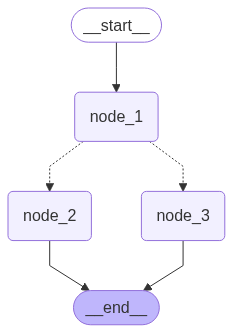

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol.

This provides a standard way to execute LangChain components. 
 
`invoke` is one of the standard methods in this interface.

The input is a dictionary `{"graph_state": "Hi, this is lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node.

It progresses through the defined nodes (`node_1`, `node_2`, `node_3`) in order.

The conditional edge will traverse from node `1` to node `2` or `3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the `END` node.

In [5]:
graph.invoke({"graph_state" : "Hi, this is Trisha."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Trisha. I am happy!'}

In [6]:
graph.invoke({"graph_state" : "Hi, this is Trisha."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Trisha. I am sad!'}

`invoke` runs the entire graph synchronously.

This waits for each step to complete before moving to the next.

It returns the final state of the graph after all nodes have executed.

In this case, it returns the state after `node_3` has completed: 

```
{'graph_state': 'Hi, this is Lance. I am sad!'}
```

## Chain

### Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

### Messages


Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [10]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Trisha"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Baleen whales in the US.", name="Trisha"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Trisha

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Trisha

I want to learn about the best place to see Baleen whales in the US.


### Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [11]:
!pip install -qU langchain-groq


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
# llm = ChatOpenAI(model="gpt-4o")
llm = ChatGroq(model="llama-3.1-8b-instant", api_key='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')
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [13]:
result

AIMessage(content="If you're interested in seeing baleen whales in the US, you're in luck because there are several excellent locations along the coast. Here are a few top recommendations:\n\n1. **Alaska's Inside Passage**: The Inside Passage is one of the best places in the US to see humpback whales (Megaptera novaeangliae), gray whales (Eschrichtius robustus), and other baleen whales. Take a cruise or tour to witness these magnificent creatures up close.\n2. **Montana de Oro State Park, California**: This park on the central coast of California is a prime spot for gray whale sightings during their annual migrations (December to May).\n3. **Puget Sound, Washington**: From late fall to early spring, Puget Sound is home to orcas (which are actually toothed whales, but they can be seen alongside baleen whales) and gray whales. Take a whale-watching tour to spot these amazing creatures.\n4. **Cape Cod, Massachusetts**: While not as abundant as in Alaska or California, Cape Cod is a great 

In [15]:
result.response_metadata

{'token_usage': {'completion_tokens': 348,
  'prompt_tokens': 92,
  'total_tokens': 440,
  'completion_time': 0.519460374,
  'prompt_time': 0.004167152,
  'queue_time': 0.087705178,
  'total_time': 0.523627526},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_f7bd09b454',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [16]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [17]:
def divide(a: int, b: int):
    """Divide a and b
    
    Args:
        a: first int
        b: second int"""
    
    if b!=0:
        return float(a/b)
    return "Error"

In [18]:
llm_with_tools = llm.bind_tools([multiply,divide])

In [19]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [20]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_h504',
  'type': 'tool_call'}]

In [25]:
tool_call2 = llm_with_tools.invoke([HumanMessage(content=f"What is 6 divided by 2",name="Trisha")])

In [26]:
tool_call2

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_f0h0', 'function': {'arguments': '{"a":6,"b":2}', 'name': 'divide'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 297, 'total_tokens': 316, 'completion_time': 0.028631424, 'prompt_time': 0.013673227, 'queue_time': 0.089971984, 'total_time': 0.042304651}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--30377fa7-18e2-4b0d-85fc-33b857d0cab3-0', tool_calls=[{'name': 'divide', 'args': {'a': 6, 'b': 2}, 'id': 'call_f0h0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 297, 'output_tokens': 19, 'total_tokens': 316})

In [27]:
tool_call2.tool_calls

[{'name': 'divide',
  'args': {'a': 6, 'b': 2},
  'id': 'call_f0h0',
  'type': 'tool_call'}]

### Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [28]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

### Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [29]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [30]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [31]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Trisha")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='9f1810cc-9f55-439d-8687-038a48aeb9b4'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Trisha', id='517ad2b8-1ada-4894-ae54-7185d340c205'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='a00e04b6-3378-4950-bcec-815850a735d8')]

### Our graph

Now, lets use `MessagesState` with a graph.

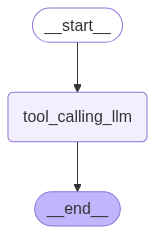

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [33]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Welcome to the interactive session. I'm ready to help you with any questions or tasks you'd like to accomplish. What would you like to do first?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [34]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wp90)
 Call ID: call_wp90
  Args:
    a: 2
    b: 3


## Router

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed. 


 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

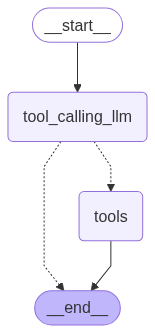

In [35]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0th3)
 Call ID: call_0th3
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


## Agent